In [831]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

In [832]:
base_dir

'/Users/jjjk84/Documents/Section4/project'

In [833]:
base_dir = os.getcwd()
df = pd.read_csv(base_dir + '/db_data.csv')
df.head()

,name,price,score,body,tannin,sweetness,acidity
0,Larose Red Blend 2019,4,4.7,4,3,1,4
1,Elevage 2000,4,4.7,5,3,1,4
2,Spring Mountain Cabernet Sauvignon 2011,4,4.7,5,3,1,3
3,Spring Mountain Cabernet Sauvignon 2016,4,4.6,5,3,1,3
4,Kai Carmenère 2008,4,4.6,4,2,1,3


In [834]:
df.duplicated().sum()

2

<AxesSubplot: xlabel='price', ylabel='Count'>

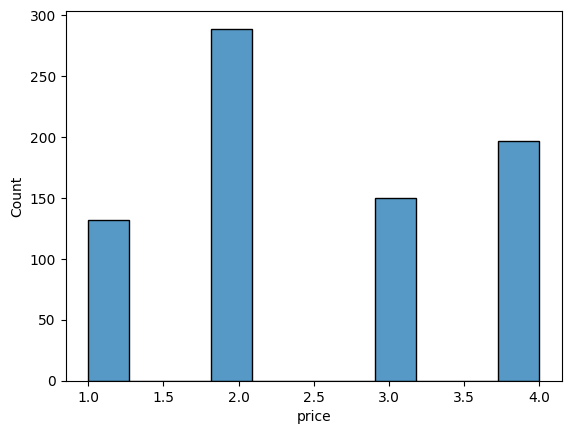

In [835]:
sns.histplot(df.price)

<AxesSubplot: xlabel='score', ylabel='price'>

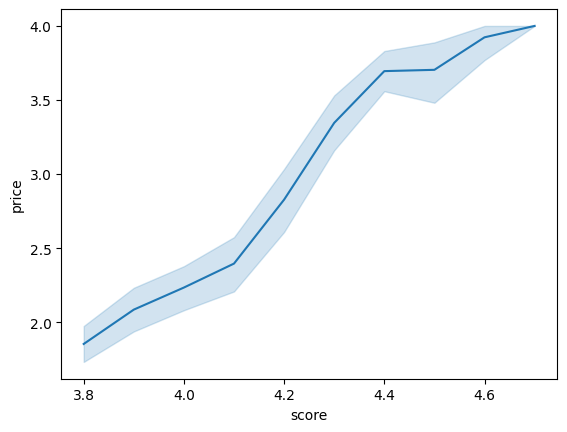

In [836]:
sns.lineplot(df, x='score', y='price')

<AxesSubplot: xlabel='body', ylabel='price'>

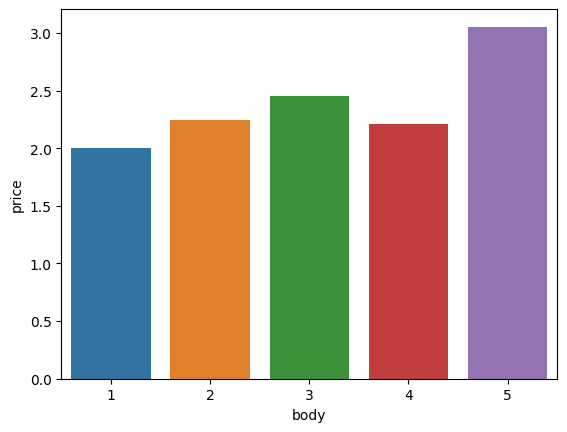

In [837]:
body_price = pd.DataFrame(df.groupby('body')['price'].mean()).reset_index()
sns.barplot(body_price, x='body', y='price')

<AxesSubplot: >

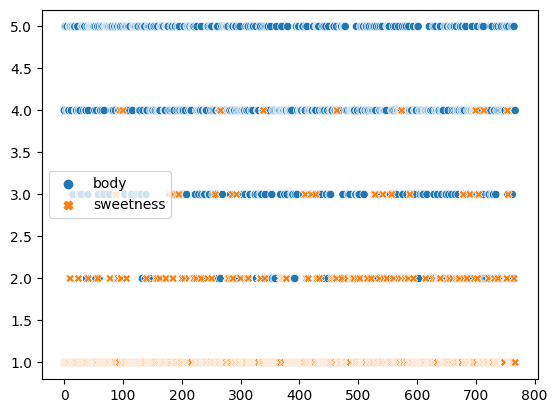

In [838]:
sns.scatterplot(df[['body', 'sweetness']])

In [839]:
len(df)

768

In [840]:
target = 'score'
features = df.drop([target, 'name'], axis=1).columns

def x_y_split(df):
    X = df[features]
    y = np.log(df[target])
    return X, y

X, y = x_y_split(df)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [841]:
X_train.shape, y_train.shape

((614, 5), (614,))

In [842]:
model = XGBRegressor(random_state=42, n_estimators = 200,
                 max_depth = 20,
                learning_rate = 0.15,
                 min_child_weight = 20)

In [843]:
kf = KFold(n_splits=7)
result = []
for train_idx, test_idx in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(X_train_cv, y_train_cv)

    y_pred_cv = model.predict(X_val_cv)

    r2 = r2_score(y_val_cv, y_pred_cv)
    result.append(r2)
result_avg = np.array(result).mean()
print(result_avg)

0.35727018091711454


In [844]:
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print(r2_test)

0.42364462277463644


In [845]:
test = pd.DataFrame(columns=list(X_test.columns))
test = test.append({'price': 3, 'body' : 5, 'tannin' : 1, 'sweetness' : 5, 'acidity' : 2}, ignore_index=True)
test = test.astype('int')
test

/var/folders/_8/qgs27d456t3f7jzjt6dj6b140000gn/T/ipykernel_50290/1544616550.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append({'price': 3, 'body' : 5, 'tannin' : 1, 'sweetness' : 5, 'acidity' : 2}, ignore_index=True)


,price,body,tannin,sweetness,acidity
0,3,5,1,5,2


In [846]:
test.astype('int')

,price,body,tannin,sweetness,acidity
0,3,5,1,5,2


In [849]:
np.exp(model.predict(test)[0])

3.8955073

In [848]:
import pickle

with open('model.pkl', 'wb') as pickkle_file:
    pickle.dump(model, pickkle_file)